# Proyecto Aplicado

### Alumnos:
- Alejandro Sandoval Arellano
- Álvaro Quinteros Aguilera
- Daniel Ortiz Pacheco
- Elio Francisco Revilla Pérez


In [2]:
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import pandas as pd
import spacy
import ast
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA  # Puedes elegir PCA o t-SNE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get Images' Embeddings

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.image_name = []

        # Recorre el directorio de datos para obtener las rutas de las imágenes y las etiquetas
        for label in os.listdir(root_dir):
            image_name = os.path.join(root_dir, label)
            try:
                _ = Image.open(image_name).convert("RGB")
                self.image_paths.append(image_name)
                self.image_name.append(label.replace('.jpg', ''))
            except Exception:
                pass

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = self.image_name[idx]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, image_name

# Ruta a la carpeta que contiene las imágenes etiquetadas
dataset_path = './images'

# Define las transformaciones que deseas aplicar a las imágenes
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Crea una instancia de tu conjunto de datos personalizado
custom_dataset = CustomImageDataset(root_dir=dataset_path, transform=transform)
dloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

/Users/dany/.local/share/virtualenvs/python-ai-env-cTwd-LQ7/lib/python3.11/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /Users/dany/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/dany/.local/share/virtualenvs/python-ai-env-cTwd-LQ7/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dany/.local/share/virtualenvs/python-ai-env-cTwd-LQ7/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
layer = model._modules.get('avgpool')

# Definiendo una función para copiar los embeddings de la penúltima capa
def copy_embeddings(m, i, o):
    """Copia los embeddings de la penúltima capa.
    Args:
    m (torch.nn.Module): El módulo (capa) desde el cual se están copiando los embeddings.
    i (tuple): Una tupla que contiene los tensores de entrada al módulo.
    o (torch.Tensor): El tensor de salida del módulo.
    """
    # Reduciendo las dimensiones del tensor de salida, deshaciéndose de las dimensiones espaciales,
    # convirtiendo el tensor a un arreglo de NumPy y luego a una lista de Python
    o = o[:, :, 0, 0].detach().numpy().tolist()

    # Añadiendo los embeddings copiados a la lista 'outputs'
    outputs.append(o)

# Inicializando una lista para almacenar los embeddings copiados
outputs = []

# Registrando la función 'copy_embeddings' como un hook de la capa 'layer'.
# Este hook se llamará cada vez que se realice un forward pass a través de 'layer',
# permitiendo copiar los embeddings.
hook = layer.register_forward_hook(copy_embeddings)

In [8]:
ids = []
# Iterando sobre el cargador de datos 'dloader', que contiene pares de imágenes y etiquetas
for X, y in tqdm(dloader):
    ids += y
    # Realizando un paso hacia adelante (forward pass) a través del modelo 'model' con las imágenes 'X'
    # El resultado de la propagación hacia adelante se descarta con '_'
    _ = model(X)

100%|██████████| 3982/3982 [23:20<00:00,  2.84it/s]


In [54]:
df = pd.DataFrame({
    'id': ids,
    'embedding': [list(emb) for embs in outputs for emb in embs]
})

df.to_csv('images_embeddings.csv')

# Get Texts' Embeddings

In [3]:
dff = pd.read_csv('dataset_curso.csv')
dff

,clean_title,created_utc,id,image_url,linked_submission_id,num_comments,score,upvote_ratio,2_way_label
0,portland water supply to be flushed after teen...,1.397748e+09,239vnh,https://external-preview.redd.it/h_E8kwTPvvR6L...,NaN,6.0,5,0.78,1
1,when all the pundits said clinton would win th...,1.528325e+09,8p52o3,https://preview.redd.it/egrrssrbkg211.jpg?widt...,NaN,1.0,4,0.84,0
2,king femme dirty kitty this is my first time i...,1.563147e+09,cd9y6e,https://preview.redd.it/f5wxn4b5uca31.jpg?widt...,NaN,2.0,33,1.00,0
3,angry human yelling at peaceful human,1.439152e+09,3gduaq,https://external-preview.redd.it/8OkDeADBmg78e...,NaN,10.0,23,0.73,1
4,oh i get it now haha,1.428162e+09,cq10fmf,http://i.imgur.com/fpuSTrf.jpg,31c39q,NaN,1,NaN,0
...,...,...,...,...,...,...,...,...,...
56395,early life of hugo chavez tie you up in knots ...,1.421669e+09,2sxfbh,https://external-preview.redd.it/80noZMkqENF8L...,NaN,3.0,1,0.55,0
56396,cutouts,1.407073e+09,cjfnopb,http://i.imgur.com/VJXiGGH%2ejpg,2ci1dk,NaN,1,NaN,0
56397,just as excited about coffee as i am,1.527877e+09,8nu3wh,https://preview.redd.it/l5q7twi4kf111.jpg?widt...,NaN,1.0,5,1.00,0
56398,we dissected this fake news site linking denze...,1.488385e+09,5wwv00,https://external-preview.redd.it/0jL1zCPRrSb6t...,NaN,7.0,754,0.92,0


In [4]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

def get_emb(text):
    doc = nlp(text)
    return doc.vector

dff['text_emb'] = dff['clean_title'].apply(get_emb)

# Explore Data Analyze 

In [5]:
df = pd.read_csv('images_embeddings.csv')
dff = pd.merge(df, dff, how='outer', on='id')

def transform(x):
    if type(x) == float:
        return np.zeros(512)
    if type(x) == str:
        return np.array(ast.literal_eval(x))

    return x

dff['img_embedding'] = dff['embedding'].apply(transform)
df = dff
dff

,Unnamed: 0,id,embedding,clean_title,created_utc,image_url,linked_submission_id,num_comments,score,upvote_ratio,2_way_label,text_emb,img_embedding
0,0.0,cj0g29,"[0.7892938852310181, 1.2542603015899658, 3.332...",ford cortina with a smaller ford cortina inside,1.564343e+09,https://preview.redd.it/uuosygkhm3d31.jpg?widt...,NaN,0.0,19,0.89,1,"[-0.021617532, -0.6204707, 0.42031112, 0.33627...","[0.7892938852310181, 1.2542603015899658, 3.332..."
1,1.0,d2a9vw,"[2.08537220954895, 0.8169383406639099, 0.70217...",bit into my pickle and found a ghost face,1.568134e+09,https://preview.redd.it/hhgm4rmzosl31.jpg?widt...,NaN,2.0,10,0.72,1,"[0.2731337, -0.2498249, -0.10734738, -0.296270...","[2.08537220954895, 0.8169383406639099, 0.70217..."
2,2.0,32vwwz,"[0.5105404853820801, 0.28021764755249023, 0.95...",army morale low despite year m optimism program,1.429242e+09,https://external-preview.redd.it/ZBbhxVHiphuO8...,NaN,630.0,2223,0.94,1,"[0.25315344, -0.7669935, -0.15399161, -0.34570...","[0.5105404853820801, 0.28021764755249023, 0.95..."
3,3.0,ztpg0,"[0.5009039640426636, 1.0230634212493896, 0.317...",afroamerican solidarity with the oppressed peo...,1.347549e+09,https://external-preview.redd.it/RRXW3XPm3RL5f...,NaN,0.0,9,0.80,0,"[0.18981265, -0.4375021, -0.027818955, 0.14170...","[0.5009039640426636, 1.0230634212493896, 0.317..."
4,4.0,88yrib,"[0.3697797358036041, 1.8819571733474731, 0.789...",mainers create rescue pipeline for stray dogs ...,1.522670e+09,https://external-preview.redd.it/FAk429MTw92v5...,NaN,1.0,12,0.69,1,"[-0.20819673, -0.1487857, 0.07917815, 0.030468...","[0.3697797358036041, 1.8819571733474731, 0.789..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56395,NaN,ciqfp5f,NaN,too many snipers,1.404712e+09,http://i.imgur.com/K7oyW9S.jpg,2a0hse,NaN,1,NaN,0,"[-0.033940356, 0.40069517, -0.30004802, 1.3182...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56396,NaN,cqtj470,NaN,thats right dogg fck the man,1.430369e+09,http://i.imgur.com/9cPqCdv.jpg,34cym5,NaN,-1,NaN,0,"[0.18584359, -0.16933477, 0.21147011, 0.197398...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56397,NaN,cirxrpo,NaN,it was larrys last day before retirement,1.404853e+09,http://i.imgur.com/2BauMZM.jpg,2a67ck,NaN,8,NaN,0,"[0.087804735, -0.40624243, -0.07308658, -0.420...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56398,NaN,chx45kn,NaN,cutouts,1.401712e+09,http://i.imgur.com/f7VXJQF%2ejpg,273t4v,NaN,1,NaN,0,"[-0.9939233, 1.5779564, -0.72062707, 2.1054916...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


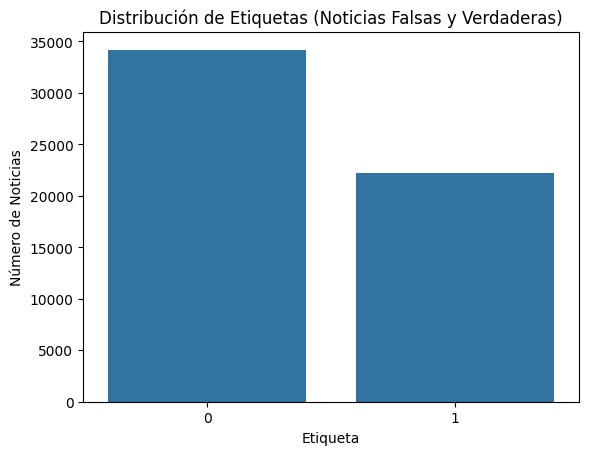

In [6]:
# Contar el número de noticias falsas y verdaderas
count_labels = df['2_way_label'].value_counts()

# Crear un gráfico de barras
sns.barplot(x=count_labels.index, y=count_labels.values)

# Personalizar el gráfico
plt.xlabel('Etiqueta')
plt.ylabel('Número de Noticias')
plt.title('Distribución de Etiquetas (Noticias Falsas y Verdaderas)')

# Mostrar el gráfico
plt.show()

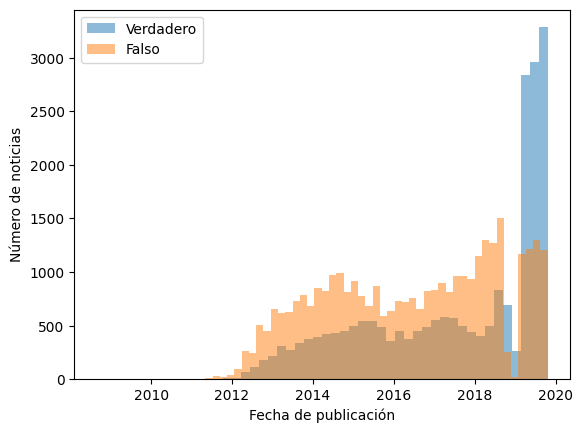

In [7]:
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

# Histograma de fechas de publicación
plt.hist(df[df['2_way_label'] == 1]['created_utc'], bins=50, alpha=0.5, label='Verdadero')
plt.hist(df[df['2_way_label'] == 0]['created_utc'], bins=50, alpha=0.5, label='Falso')
plt.xlabel('Fecha de publicación')
plt.ylabel('Número de noticias')
plt.legend()
plt.show()

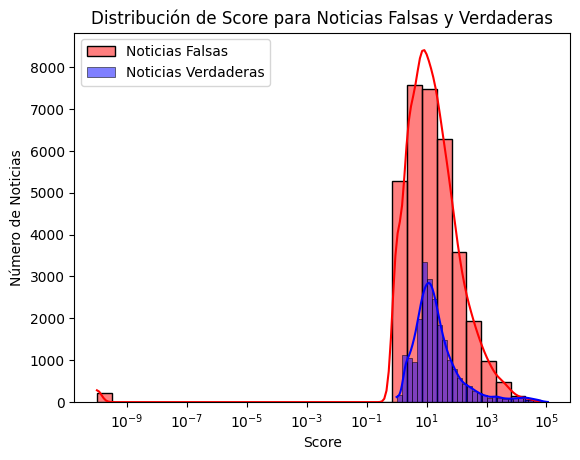

In [8]:
df['score'] += 0.0000000001
noticias_falsas = df[df['2_way_label'] == 0]
noticias_verdaderas = df[df['2_way_label'] == 1]

def plot(bins=20):
    # Crear histograma usando seaborn
    sns.histplot(noticias_falsas['score'], bins=bins, color='red', label='Noticias Falsas', kde=True, log_scale=True)
    sns.histplot(noticias_verdaderas['score'], bins=bins, color='blue', label='Noticias Verdaderas', kde=True, log_scale=True)
    # Personalizar el gráfico
    plt.xlabel('Score')
    plt.ylabel('Número de Noticias')
    plt.title('Distribución de Score para Noticias Falsas y Verdaderas')
    # Mostrar la leyenda
    plt.legend()
    # Mostrar el histograma
    plt.show()


plot(30)

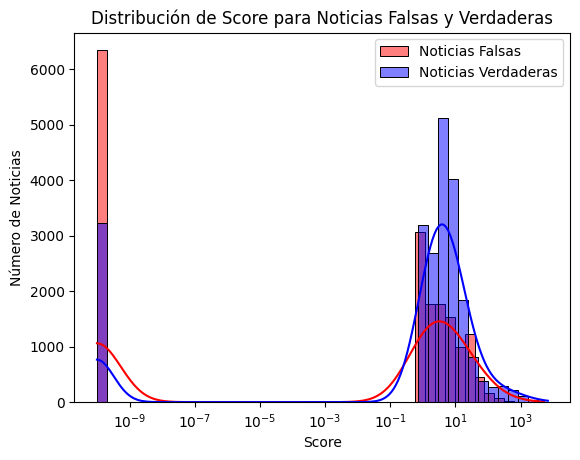

In [9]:
df['num_comments'] += 0.0000000001
noticias_falsas = df[df['2_way_label'] == 0]
noticias_verdaderas = df[df['2_way_label'] == 1]

def plot(bins=20):
    # Crear histograma usando seaborn
    sns.histplot(noticias_falsas['num_comments'], bins=bins, color='red', label='Noticias Falsas', kde=True, log_scale=True)
    sns.histplot(noticias_verdaderas['num_comments'], bins=bins, color='blue', label='Noticias Verdaderas', kde=True, log_scale=True)
    # Personalizar el gráfico
    plt.xlabel('Score')
    plt.ylabel('Número de Noticias')
    plt.title('Distribución de Score para Noticias Falsas y Verdaderas')
    # Mostrar la leyenda
    plt.legend()
    # Mostrar el histograma
    plt.show()

plot(45)

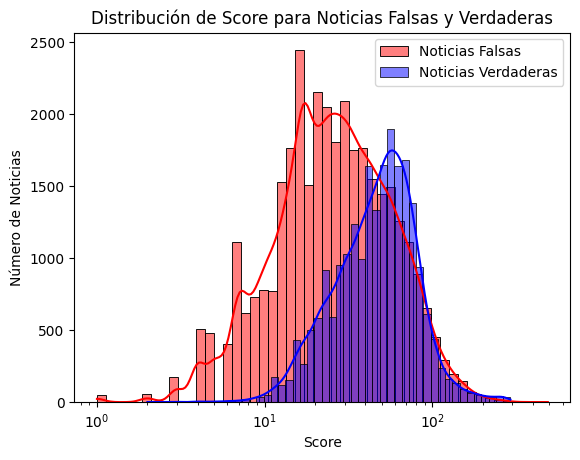

In [11]:
df['title_length'] = df['clean_title'].apply(len)

noticias_falsas = df[df['2_way_label'] == 0]
noticias_verdaderas = df[df['2_way_label'] == 1]

def plot(bins=20):
    # Crear histograma usando seaborn
    sns.histplot(noticias_falsas['title_length'], bins=bins, color='red', label='Noticias Falsas', kde=True, log_scale=True)
    sns.histplot(noticias_verdaderas['title_length'], bins=bins, color='blue', label='Noticias Verdaderas', kde=True, log_scale=True)
    # Personalizar el gráfico
    plt.xlabel('Score')
    plt.ylabel('Número de Noticias')
    plt.title('Distribución de Score para Noticias Falsas y Verdaderas')
    # Mostrar la leyenda
    plt.legend()
    # Mostrar el histograma
    plt.show()

plot(50)

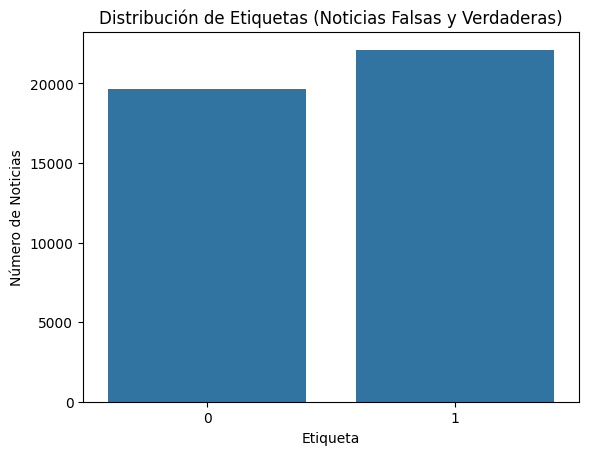

In [12]:
image_dataset = df[~df['image_url'].isna() & df['image_url'].str.startswith('https')] 

# Contar el número de noticias falsas y verdaderas
count_labels = image_dataset['2_way_label'].value_counts()

# Crear un gráfico de barras
sns.barplot(x=count_labels.index, y=count_labels.values)

# Personalizar el gráfico
plt.xlabel('Etiqueta')
plt.ylabel('Número de Noticias')
plt.title('Distribución de Etiquetas (Noticias Falsas y Verdaderas)')

# Mostrar el gráfico
plt.show()

<Axes: >

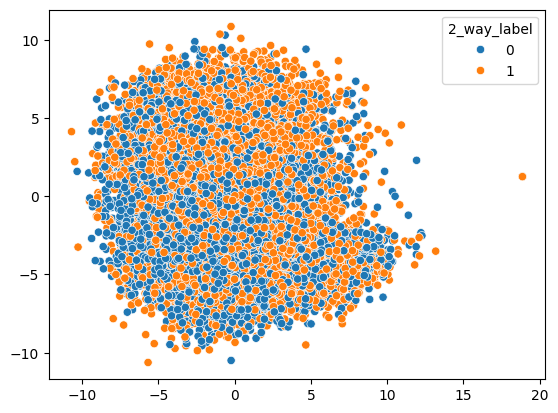

In [13]:
pca = PCA(n_components=2)
X = pca.fit_transform(np.vstack(image_dataset['img_embedding'].to_numpy()))

sns.scatterplot(x=X[:,0], y =X[:,1], hue=image_dataset['2_way_label'])

# First Proposal

In [14]:
def transform(row):
    result = [x for x in row['text_emb']]
    return np.array(result + [x for x in row['img_embedding']])

dff['total_emb'] = dff.apply(transform, axis=1)

In [15]:
matriz_numpy = np.vstack(dff['total_emb'].to_numpy())
matriz_numpy.shape

(56400, 608)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(matriz_numpy, dff['2_way_label'], test_size=0.2, random_state=42)

In [75]:

pipeline = Pipeline([
    ('pca', PCA(n_components=50)),
    ('svm', SVC(kernel='linear', C=1.0))
])

pipeline.fit(X_train, y_train)

accuracy = pipeline.score(X_test, y_test)
print(f'Accuracy: {accuracy}')


Accuracy: 0.7506205673758866


In [18]:

pipeline = Pipeline([
    ('pca', PCA(
        n_components= 455, svd_solver= 'arpack', random_state=42
    )),
    ('svm', SVC(
        kernel= 'poly', C= 1.1, random_state=42
    ))
])

pipeline.fit(X_train, y_train)

accuracy = pipeline.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7952127659574468


# TODOs

- Clear the dataset  
- EDA for textual data
- Test other models
- Metrics analysis
- Do the front end

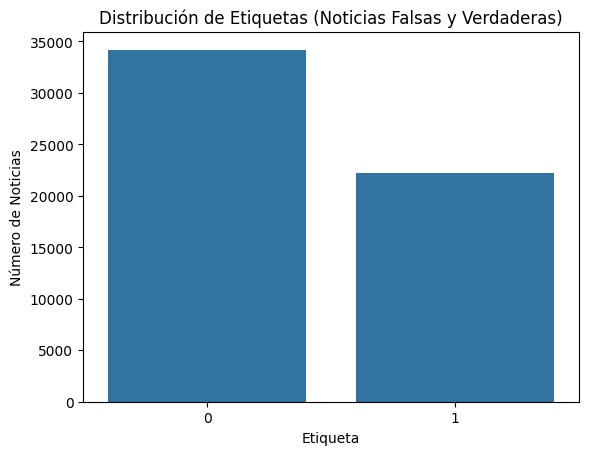

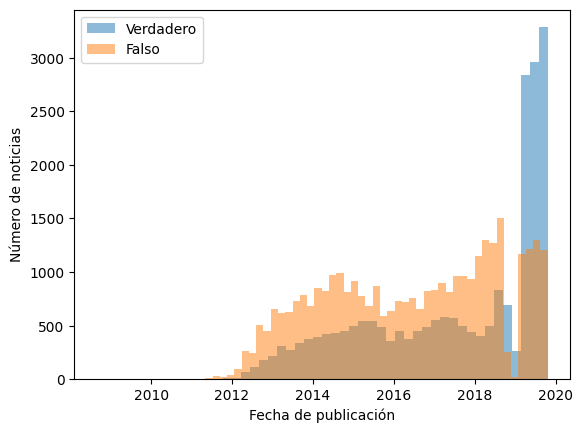

In [85]:
# Convertir 'created_utc' a formato de fecha



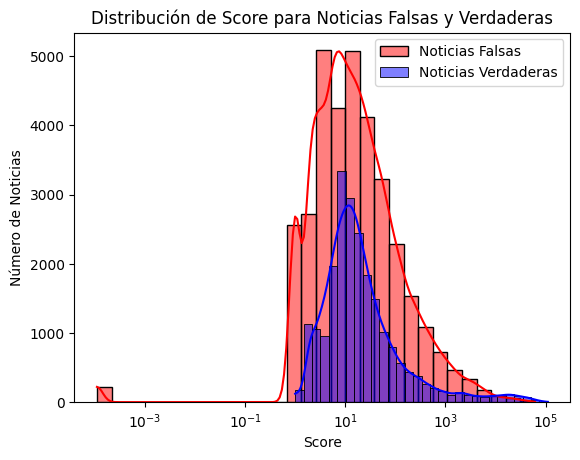

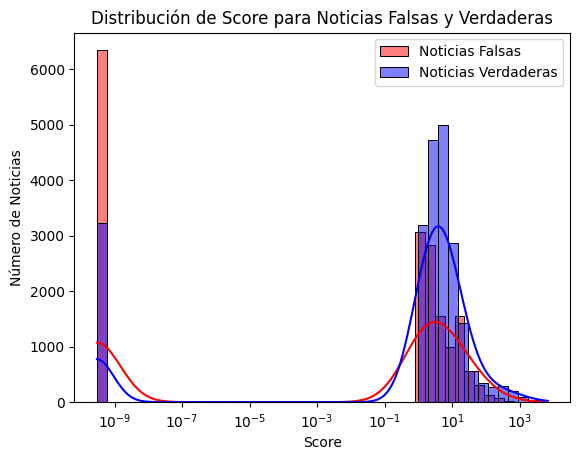

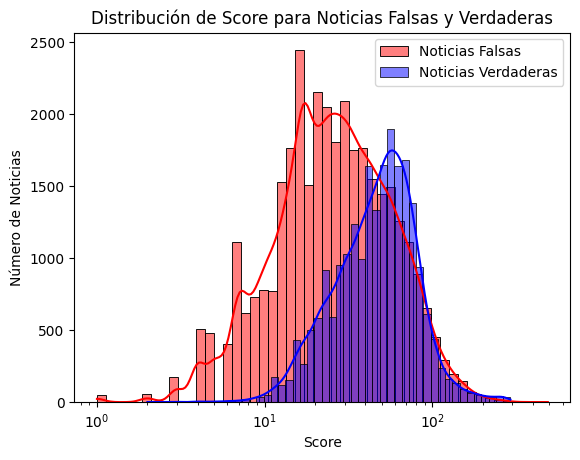

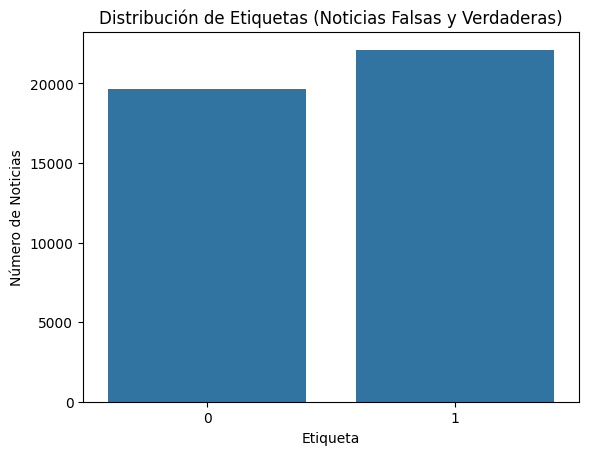

(41726, 512)

<Axes: >

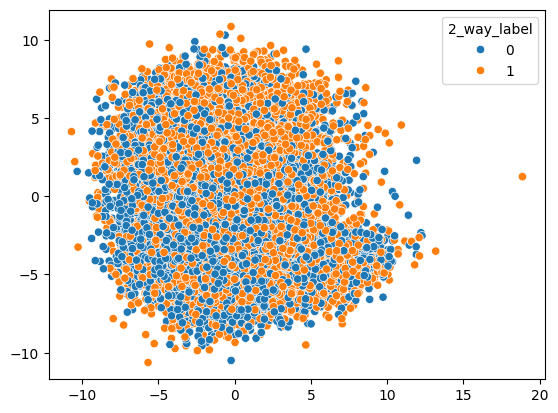

In [88]:
from sklearn.feature_extraction.text import CountVectorizer

# Tokenización y conteo de palabras en títulos
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_title'])

# Obtén las palabras más frecuentes en títulos
word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': X.sum(axis=0).A1})
word_freq = word_freq.sort_values(by='count', ascending=False)
print(word_freq.head(10))


              word  count
18246         like   1627
19043          man   1319
21406          new   1131
18566        looks   1038
8916           dog    925
16865         just    875
4825           cat    829
8692   discussions    777
32968        trump    729
13996        happy    672


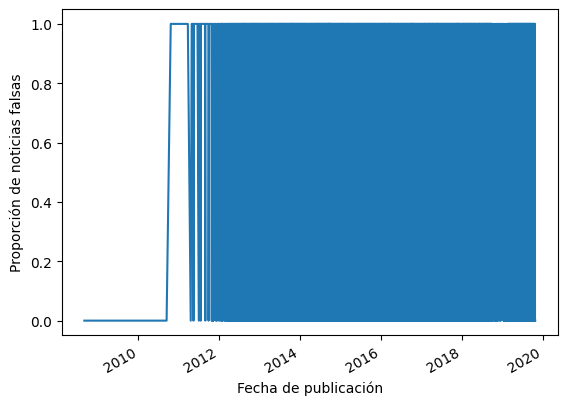

In [90]:
# Convertir 'created_utc' a formato de fecha
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

# Crear una serie temporal
temporal_data = df.groupby(['created_utc', '2_way_label']).size().unstack().fillna(0)

# Calcular la proporción de noticias falsas
temporal_data['proporcion_falsas'] = temporal_data[0] / (temporal_data[1] + temporal_data[0])

# Graficar la evolución temporal
temporal_data['proporcion_falsas'].plot()
plt.xlabel('Fecha de publicación')
plt.ylabel('Proporción de noticias falsas')
plt.show()


In [ ]:
# from gensim import corpora, models
# import gensim

# # Preprocesamiento de texto (tokenización, eliminación de stopwords, etc.)

# # Crear un diccionario de términos
# dictionary = corpora.Dictionary(text_data)

# # Crear una matriz de términos y documentos
# corpus = [dictionary.doc2bow(text) for text in text_data]

# # Entrenar el modelo LDA
# lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# # Imprimir los tópicos
# for idx, topic in lda_model.print_topics():
#     print(f'Tópico {idx}: {topic}')


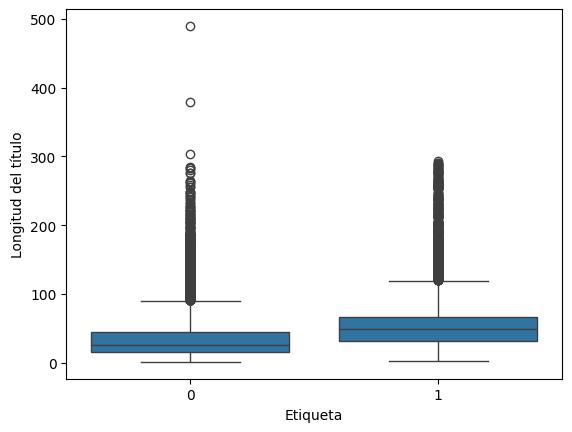

In [79]:
# Longitud de los títulos
df['title_length'] = df['clean_title'].apply(len)

# Boxplot de longitud de títulos por etiqueta
sns.boxplot(x='2_way_label', y='title_length', data=df)
plt.xlabel('Etiqueta')
plt.ylabel('Longitud del título')
plt.show()


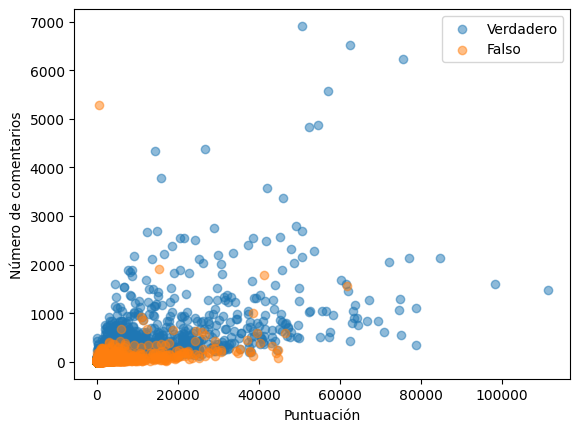

In [81]:
# Gráfico de dispersión de puntuación vs. número de comentarios
plt.scatter(df[df['2_way_label'] == 1]['score'], df[df['2_way_label'] == 1]['num_comments'], label='Verdadero', alpha=0.5)
plt.scatter(df[df['2_way_label'] == 0]['score'], df[df['2_way_label'] == 0]['num_comments'], label='Falso', alpha=0.5)
plt.xlabel('Puntuación')
plt.ylabel('Número de comentarios')
plt.legend()
plt.show()
